In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib as mpl
import scipy
import warnings
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
sns.set_style("white")
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.stats import pearsonr
from sklearn.model_selection import KFold


In [45]:
import pandas as pd, numpy as np, pickle
df=pd.read_csv('data/SAdata_allMeasures.csv') 
Xall,yall=df.iloc[:,:-1],df.iloc[:,-1]

In [46]:
df

,age,gender,yearDriving,drivingFrequency,videoLength,decisionTime,decisionMade,correctDecision,danger,difficulty,...,fMax,backMirror,leftMirror,rightMirror,road,sky,pupilChange,pupilMean,pupilStd,SA
0,26,1,20,1,12,4.80219,4,0,20.0,89,...,874.5,0,5,3,24,0,0.733955,3.818149,0.169227,0.641219
1,26,1,20,1,6,4.91667,1,0,10.0,99,...,1014.0,2,2,1,9,2,0.623622,3.743575,0.178412,0.354868
2,26,1,20,1,1,2.20933,2,0,99.0,99,...,259.5,0,0,0,3,0,0.205836,3.326857,0.079828,0.561225
3,26,1,20,1,3,2.63056,1,0,9.0,79,...,636.0,0,1,0,6,0,0.020505,3.643468,0.034005,0.422067
4,26,1,20,1,9,2.42632,1,0,9.0,96,...,807.0,5,4,1,13,0,0.632357,3.669544,0.196699,0.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,27,1,18,4,3,1.26232,4,4,88.0,49,...,748.5,1,0,0,1,0,0.342905,2.722796,0.116738,0.319177
1052,27,1,18,4,6,1.14512,2,2,41.0,7,...,1365.0,5,1,0,8,0,0.486911,2.799394,0.122229,0.246157
1053,27,1,18,4,12,1.49713,1,1,8.0,5,...,1756.0,5,2,0,15,0,0.405155,2.826210,0.118613,0.055587
1054,27,1,18,4,1,1.53394,1,1,68.0,65,...,1026.0,0,0,0,1,0,0.174587,2.480916,0.078884,0.218539


In [47]:
from datetime import datetime
import lightgbm as lgb

# specify your configurations as a dict
params = {
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 100,
    'learning_rate': 0.05,
   # 'feature_fraction': 0.9,
   # 'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_pre_filter': False
}

X = np.array(Xall)
Y = np.array(yall)
Y = 1 - Y;
rmse_v = []
mae_v = []
Corr_v = []
Xdata = []
shap_values = []

startTime = datetime.now()
count = 0;
skf = KFold(n_splits=10, shuffle=True, random_state=0)
for train_index, test_index in skf.split(X,Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    Xdata.append(X_test)

    count = count + 1
    print(count)
    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_test, y_test)

    model = lgb.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=False, early_stopping_rounds=100)
    y_pred = model.predict(X_test)
            
    rmse_v.append(np.sqrt(mean_squared_error(y_test, y_pred)))     
    mae_v.append(mean_absolute_error(y_test, y_pred))    
    Corr_v.append(np.corrcoef(y_test,y_pred))

    explainer = shap.TreeExplainer(model, X_train)
    shap_values.append(explainer.shap_values(X_test))
    print(datetime.now()-startTime)
print(np.mean(rmse_v))
print(np.mean(mae_v))
print(np.mean(Corr_v))

1
0:00:00.722478
2
0:00:01.043443
3
0:00:01.854902
4
0:00:02.303593
5
0:00:02.732648
6
0:00:03.098048
7
0:00:03.382344
8
0:00:04.287984
9
0:00:04.895784
10
0:00:05.367452
0.10917175497310547
0.08562712417596555
0.7956999565381616


In [48]:
print(np.mean(rmse_v))
print(np.mean(mae_v))
print(np.mean(Corr_v))
print(np.std(rmse_v))
print(np.std(mae_v))
print(np.std(Corr_v))

0.10917175497310547
0.08562712417596555
0.7956999565381616
0.01004318374714213
0.008649698270674105
0.21088818168316514


In [49]:
df.columns

Index(['age', 'gender', 'yearDriving', 'drivingFrequency', 'videoLength',
       'decisionTime', 'decisionMade', 'correctDecision', 'danger',
       'difficulty', 'carPlacedLeft', 'carPlacedRight', 'numS', 'sAmpMean',
       'sAmpStd', 'sAmpMax', 'numF', 'fMean', 'fStd', 'fMax', 'backMirror',
       'leftMirror', 'rightMirror', 'road', 'sky', 'pupilChange', 'pupilMean',
       'pupilStd', 'SA'],
      dtype='object')

In [50]:
Xdata = np.array(Xdata)
Xdata.shape
Y = np.concatenate((Xdata[0], Xdata[1],Xdata[2],Xdata[3],Xdata[4],Xdata[5],Xdata[6],Xdata[7],Xdata[8],Xdata[9]), axis=0)
Y.shape
shap_values = np.array(shap_values)
shap_values.shape
SHAP = np.concatenate((shap_values[0], shap_values[1],shap_values[2],shap_values[3],shap_values[4],shap_values[5],shap_values[6],shap_values[7],shap_values[8],shap_values[9]), axis=0)
SHAP.shape
Xdata = pd.DataFrame(Y) 

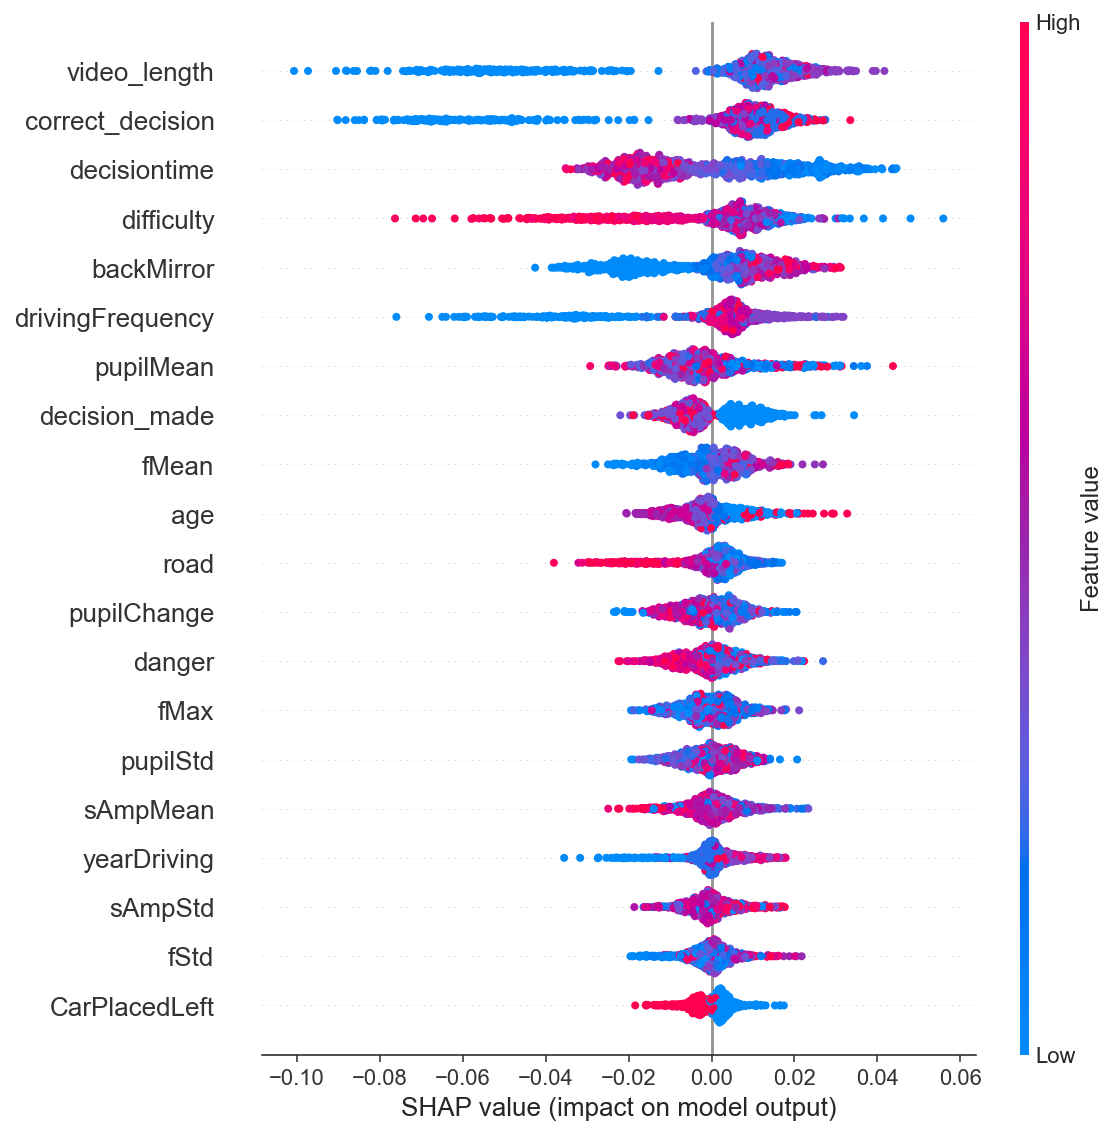

In [52]:
Xdata.columns = ['age', 'gender', 'yearDriving', 'drivingFrequency', 'video_length',
       'decisiontime', 'decision_made', 'correct_decision',
       'danger', 'difficulty', 'CarPlacedLeft', 'CarPlacedRight',
       'numS', 'sAmpMean', 'sAmpStd', 'sAmpMax', 'numF', 'fMean', 'fStd',
       'fMax', 'backMirror', 'leftMirror', 'rightMirror', 'road', 'sky',
       'pupilChange', 'pupilMean', 'pupilStd']
shap.initjs()
shap.summary_plot(SHAP, Xdata)

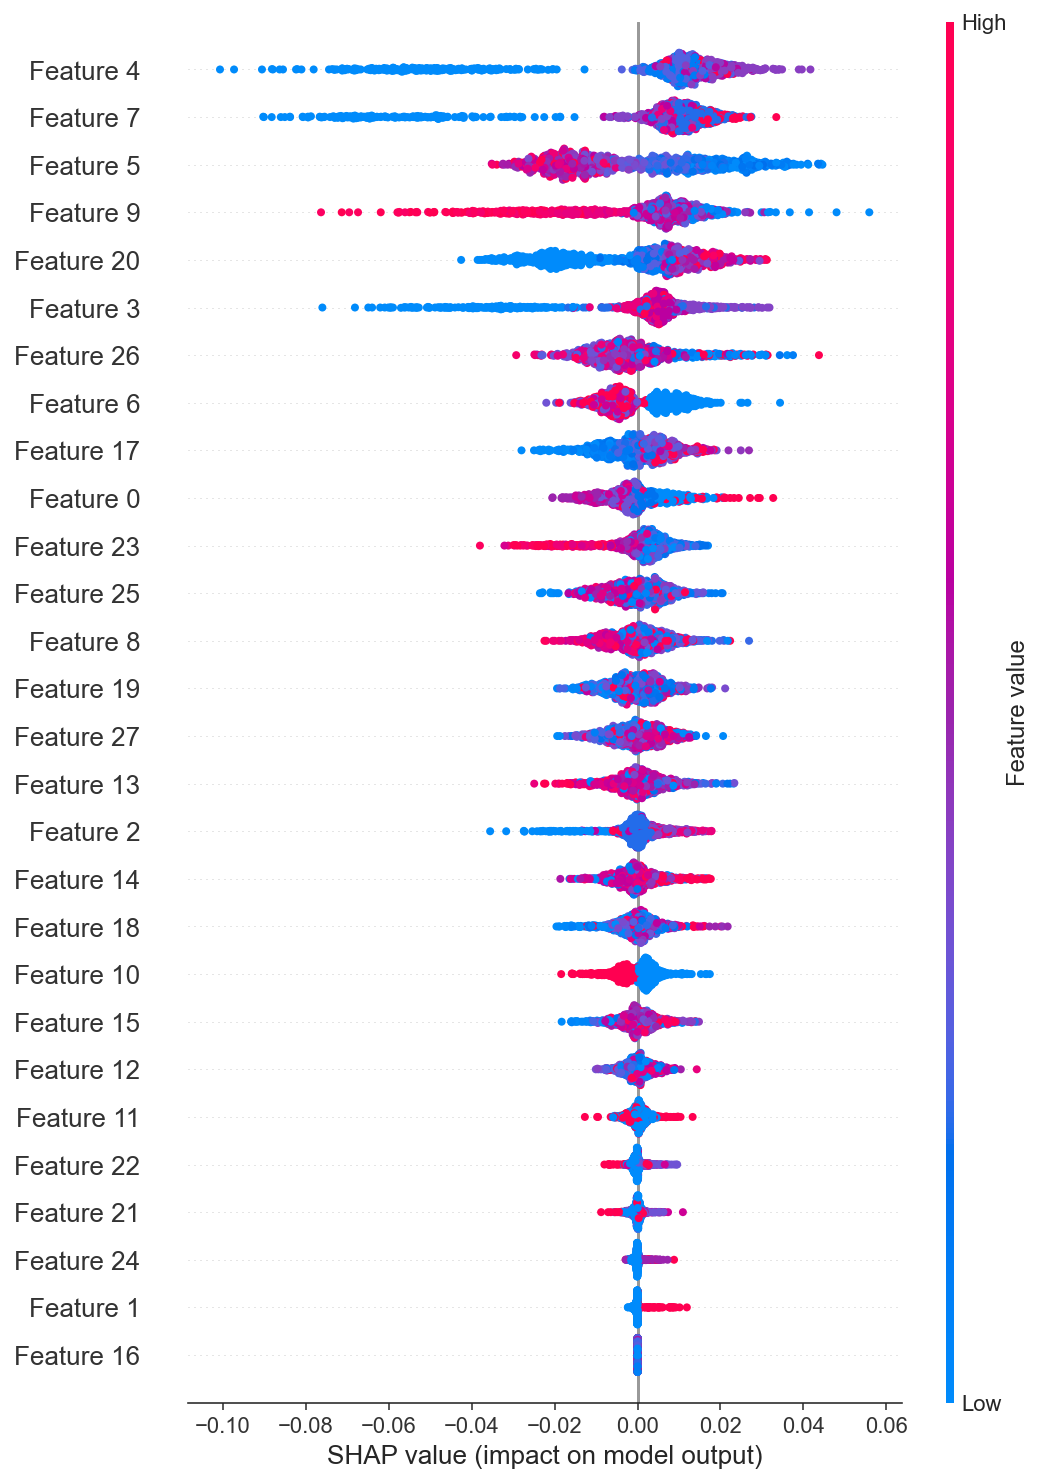

In [53]:
shap.summary_plot(SHAP, Y,max_display=28)

In [58]:
Ind = [4,7,5,9,20,3,26,6,17,0,23,25,8,19,27,13,2,14,18,10,15,12,11,22,21,24,1,16]

In [59]:
params = {
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 100,
    'learning_rate': 0.05,
   # 'feature_fraction': 0.9,
   # 'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_pre_filter': False
}
from datetime import datetime

X = np.array(Xall)
Y = np.array(yall)
Y = 1 - Y
rmseOverall = []
maeOverall = []
CorrOverall = []

rmseStdOverall = []
maeStdOverall = []
CorrStdOverall = []

shap_values = []
Xdata = [];
startTime = datetime.now()
count = 0;
                                                    
for k in range(len(Ind)):
    rmse = []
    mae = []
    Corr = []

    rmseStd = []
    maeStd = []
    CorrStd = []
    
    #k = 8
    num_i = k + 1

    X1 = X[:,Ind[0:k+1]]
    skf = KFold(n_splits=10, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X1,Y):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        Xdata.append(X_test)

        count = count + 1
        print(count)
        d_train = lgb.Dataset(X_train, y_train)
        d_valid = lgb.Dataset(X_test, y_test)


        model = lgb.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=False, early_stopping_rounds=100)
        y_pred = model.predict(X_test)
            
        rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae.append(mean_absolute_error(y_test, y_pred))          
        Corr.append(np.corrcoef(y_test,y_pred))
        #explainer = shap.TreeExplainer(model, X_train)
        #shap_values.append(explainer.shap_values(X_test))
        print(datetime.now()-startTime)
    

    rmseOverall.append(np.mean(rmse))
    rmseStdOverall.append(np.std(rmse))
    maeOverall.append(np.mean(mae))
    maeStdOverall.append(np.std(mae))
    CorrOverall.append(np.mean(Corr))
    CorrStdOverall.append(np.std(Corr))
    
    print(rmseOverall)
    print(rmseStdOverall)
    print(maeOverall)
    print(maeStdOverall)
    print(CorrOverall)
    print(CorrStdOverall)
    
    #break

    print(datetime.now()-startTime)
    


1
0:00:00.120871
2
0:00:00.148418
3
0:00:00.175803
4
0:00:00.205306
5
0:00:00.308892
6
0:00:00.333198
7
0:00:00.385233
8
0:00:00.410440
9
0:00:00.468028
10
0:00:00.518561
[0.12382780063893217]
[0.005183084483242961]
[0.09881273788007235]
[0.00512984602180303]
[0.6995314298800321]
[0.3034558203779589]
0:00:00.519191
11
0:00:00.547315
12
0:00:00.595978
13
0:00:00.667706
14
0:00:00.760644
15
0:00:00.808082
16
0:00:00.842837
17
0:00:00.896662
18
0:00:00.936920
19
0:00:01.009214
20
0:00:01.138962
[0.12382780063893217, 0.11468983852916732]
[0.005183084483242961, 0.007586057970576971]
[0.09881273788007235, 0.09133852026755981]
[0.00512984602180303, 0.006238220706075988]
[0.6995314298800321, 0.7620799069634472]
[0.3034558203779589, 0.24513487532380493]
0:00:01.139634
21
0:00:01.171701
22
0:00:01.204742
23
0:00:01.240366
24
0:00:01.287872
25
0:00:01.320406
26
0:00:01.372119
27
0:00:01.476003
28
0:00:01.522285
29
0:00:01.576168
30
0:00:01.869059
[0.12382780063893217, 0.11468983852916732, 0.11490

No handles with labels found to put in legend.


0.10802575205657824
13
0.08524617222849157
18
0.8013094775180185
16


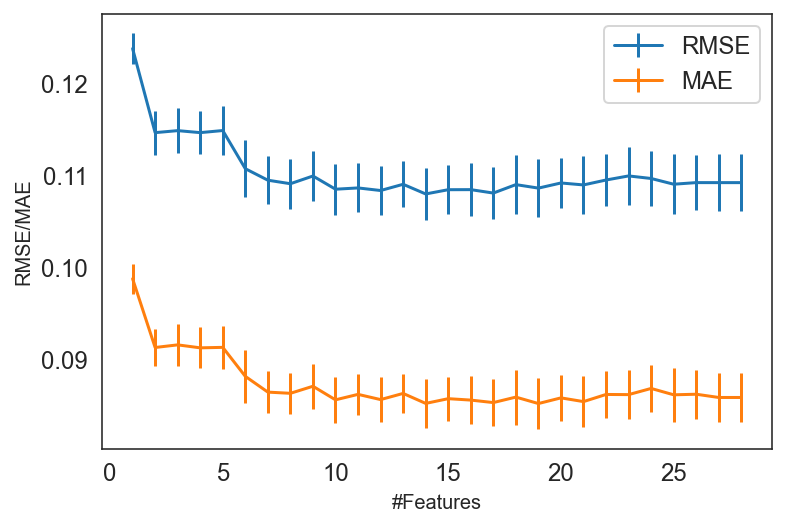

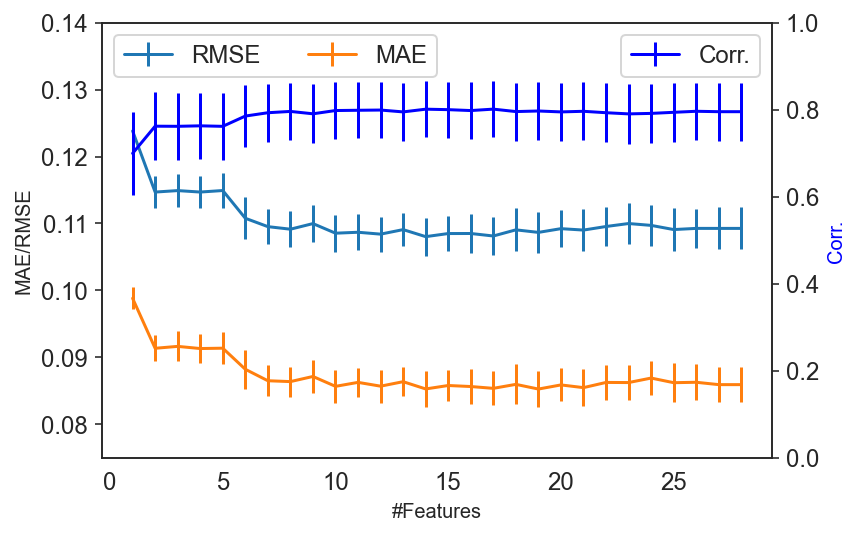

In [61]:
import matplotlib.pyplot as plt
import matplotlib

print(np.min(rmseOverall))
print(np.argmin(rmseOverall))
print(np.min(maeOverall))
print(np.argmin(maeOverall))
print(np.max(CorrOverall))
print(np.argmax(CorrOverall))
    

fig, ax = plt.subplots()
x = np.arange(len(Ind))+1
y = np.array(rmseOverall)
yerr = np.array(rmseStdOverall)/np.sqrt(10)
y1 = np.array(maeOverall)
yerr1 = np.array(maeStdOverall)/np.sqrt(10)
y2 = CorrOverall
yerr2 = np.array(CorrStdOverall)/np.sqrt(10)
#plt.figure(figsize=(10,10))
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
 
plt.errorbar(x, y , yerr=yerr,label='RMSE')
plt.errorbar(x, y1, yerr=yerr1,label='MAE')
ax.set_ylabel('RMSE/MAE')
ax.set_xlabel('#Features')
#plt.errorbar(x, y2, yerr=yerr2,label='Adj. R^2')
plt.rc('legend',fontsize=12)
plt.legend(loc='upper')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.errorbar(x, y , yerr=yerr,label='RMSE')
ax1.errorbar(x, y1, yerr=yerr1,label='MAE')
plt.rc('legend',fontsize=12)
plt.legend(loc='left')


ax2.errorbar(x, y2, yerr=yerr2,label='Corr.',color='b')
ax1.set_ylabel('MAE/RMSE')
ax1.set_ylim([0.075,.14])
ax2.set_ylabel('Corr.', color='b')
ax2.set_ylim([0,1])
ax1.set_xlabel('#Features')

ax1.legend(loc=2, ncol = len(ax1.lines))
ax2.legend(loc=1)
plt.rc('legend',fontsize=12)
#plt.legend(loc='upper')

In [62]:
params = {
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 100,
    'learning_rate': 0.05,
   # 'feature_fraction': 0.9,
   # 'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_pre_filter': False
}
from datetime import datetime

X = np.array(Xall)
Y = np.array(yall)
Y = 1 - Y
rmseOverall = []
maeOverall = []
CorrOverall = []

rmseStdOverall = []
maeStdOverall = []
CorrStdOverall = []

shap_values = []
Xdata = [];
shap_interaction_values = [];
startTime = datetime.now()
count = 0;
                                                    
for k in range(len(Ind)):
    rmse = []
    mae = []
    Corr = []

    rmseStd = []
    maeStd = []
    CorrStd = []
    
    k = 13
    num_i = k + 1

    X1 = X[:,Ind[0:k+1]]
    skf = KFold(n_splits=10, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X1,Y):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        Xdata.append(X_test)

        count = count + 1
        print(count)
        d_train = lgb.Dataset(X_train, y_train)
        d_valid = lgb.Dataset(X_test, y_test)


        model = lgb.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=False, early_stopping_rounds=100)
        y_pred = model.predict(X_test)
            
        rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae.append(mean_absolute_error(y_test, y_pred))          
        Corr.append(np.corrcoef(y_test,y_pred))
        explainer = shap.TreeExplainer(model, X_train)
        shap_values.append(explainer.shap_values(X_test))
        shap_interaction_values.append(explainer.shap_interaction_values(X_test))
        print(datetime.now()-startTime)
    

    rmseOverall.append(np.mean(rmse))
    rmseStdOverall.append(np.std(rmse))
    maeOverall.append(np.mean(mae))
    maeStdOverall.append(np.std(mae))
    CorrOverall.append(np.mean(Corr))
    CorrStdOverall.append(np.std(Corr))
    
    print(rmseOverall)
    print(rmseStdOverall)
    print(maeOverall)
    print(maeStdOverall)
    print(CorrOverall)
    print(CorrStdOverall)
    
    break

    print(datetime.now()-startTime)
    


1
0:00:00.346854
2
0:00:00.618292
3
0:00:01.392666
4
0:00:01.762091
5
0:00:01.981603
6
0:00:02.392122
7
0:00:03.134304
8
0:00:03.712559
9
0:00:04.126534
10
0:00:04.777797
[0.10802575205657824]
[0.009013514976917719]
[0.08526212607701382]
[0.00852070857952278]
[0.8011878866912703]
[0.20297754724394063]


In [63]:
Xdata = np.array(Xdata)
Xdata.shape
Y = np.concatenate((Xdata[0], Xdata[1],Xdata[2],Xdata[3],Xdata[4],Xdata[5],Xdata[6],Xdata[7],Xdata[8],Xdata[9]), axis=0)
Y.shape
shap_values = np.array(shap_values)
shap_values.shape
SHAP = np.concatenate((shap_values[0], shap_values[1],shap_values[2],shap_values[3],shap_values[4],shap_values[5],shap_values[6],shap_values[7],shap_values[8],shap_values[9]), axis=0)
SHAP.shape
Xdata = pd.DataFrame(Y) 

In [66]:
Xdata.columns = ['video_length', 'correct_decision', 'decisiontime',
 'difficulty', 'backMirror', 'drivingFrequency', 'pupilMean',
 'decision_made', 'fMean', 'age', 'road', 'pupilChange', 'danger',
 'fMax']

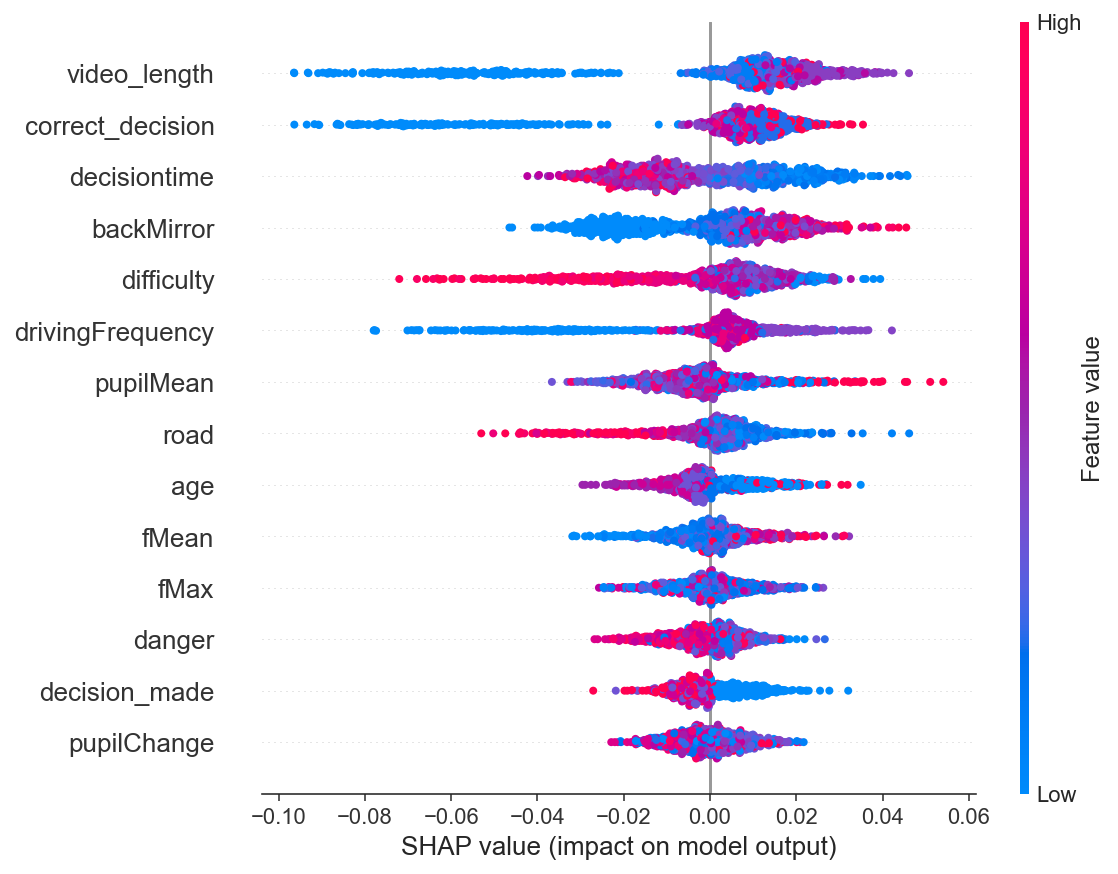

In [67]:
shap.initjs()
shap.summary_plot(SHAP, Xdata)

In [29]:
np.savetxt('XdataAll.csv', Xdata, delimiter=',')
np.savetxt('SHAPAll.csv', SHAP, delimiter=',')

In [68]:
Xall,yall=df.iloc[:,:-1],df.iloc[:,-1]
X1 = Xall[['videoLength', 'correctDecision', 'decisionTime',
 'difficulty', 'backMirror', 'drivingFrequency', 'pupilMean',
 'decisionMade', 'fMean', 'age', 'road', 'pupilChange', 'danger','fMax']]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X1)

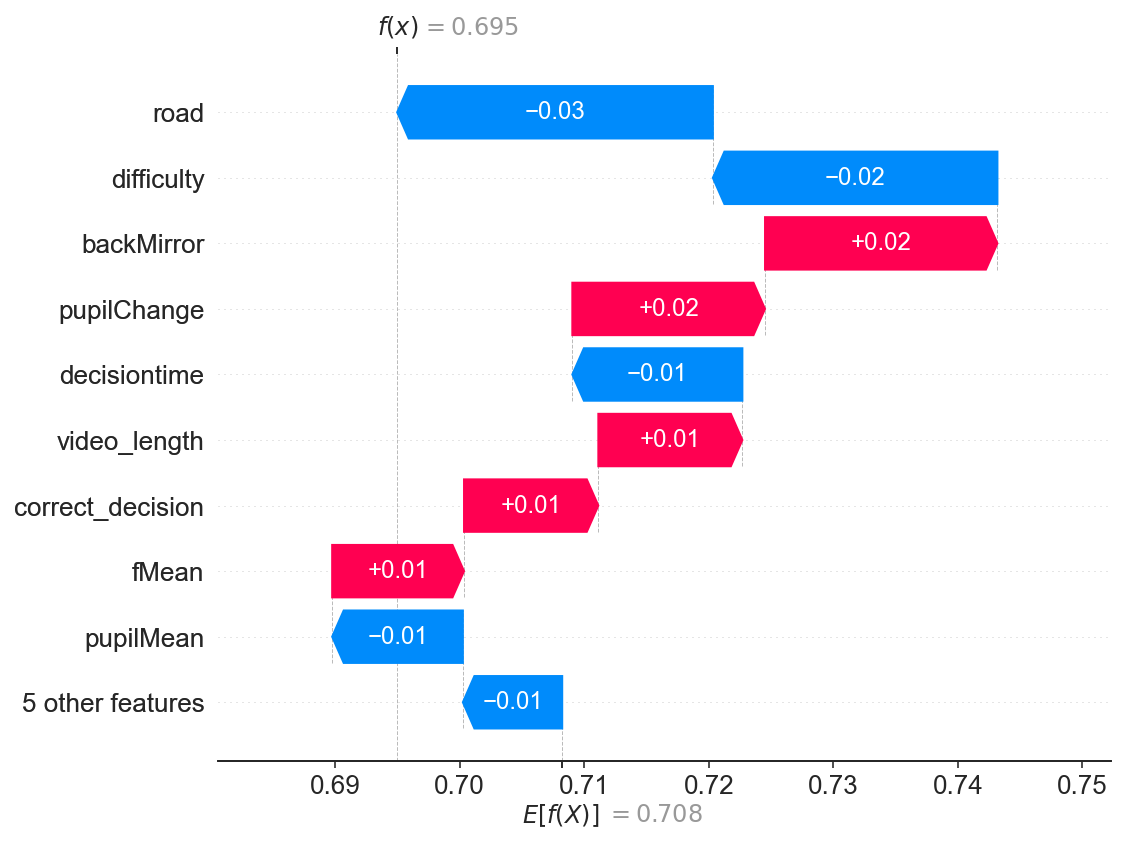

In [69]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[11], feature_names = Xdata.columns)

In [70]:
X1 = np.array(X1)

In [71]:
X1[11]

array([2.00000000e+01, 1.00000000e+00, 2.83332000e+00, 7.90000000e+01,
       7.00000000e+00, 1.00000000e+00, 3.51318236e+00, 1.00000000e+00,
       4.06023256e+02, 2.60000000e+01, 2.60000000e+01, 4.89985335e-01,
       8.00000000e+00, 3.18050000e+03])